# Regression of the Higgs transverse momentum (visible or not) in ttH multilepton 

# Authored by Pietro Vischia pietro.vischia@cern.ch

2020-09-29: warning: I think last time I used this notebook I have modified the code without recreating the plots. Or the contrary. So basically the current code likely results in different plots than those stored here.

In [160]:
# First import stuff
import pandas as pd
import math
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import pylab
import sklearn as sk
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras as kr
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten, Dropout
from keras import optimizers
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU, LeakyReLU
from tensorflow.keras.layers import BatchNormalization
import seaborn as sns
from livelossplot import PlotLossesKeras


print('Using matplotlib version', matplotlib.__version__)
print('Using sklearn version', sk.__version__)
print('Using tensorflow version', tf.__version__)
print('Using keras version', kr.__version__)

import socket
my_hostname=socket.gethostbyaddr(socket.gethostname())[0]
print('You are running on ', my_hostname)

Using matplotlib version 3.3.2
Using sklearn version 0.23.2
Using tensorflow version 2.3.0
Using keras version 2.4.3
You are running on  wudangshan


In [188]:
import os
import uproot
from root_pandas import read_root


data_tth=None
data_ttv=None
data_tt=None

useRootInput=True

if useRootInput: # the default
    # Use uproot
    idir = '{}inputs/2016_legacy_skim_v1'.format('/nfs/user/pvischia/tth/dnn/' if 'cism.ucl.be' in my_hostname else './')

    file_tth = "{}/TTHnobb_fxfx_Friend.root".format(idir)
    key = "Friends"
    data_tth_orig = read_root(file_tth, key)

    
    
    
    #tth_dnn_tree = uproot.open(file_tth)[key]
    #print("Number of jets: ", tth_dnn_tree['Hreco_nJets'].array()[0])
    #print("jets pT: ", tth_dnn_tree['Hreco_Jet_pt'].array()[0])
    #print("jets Eta: ", tth_dnn_tree['Hreco_Jet_eta'].array()[0])
    #print("lep1 pT: ", tth_dnn_tree['Hreco_Lep1_pt'].array()[0])
    #data_tth = tth_dnn_tree.arrays(outputtype=pd.DataFrame)
    ##data_tth = tth_dnn_tree.pandas.df(flatten=False)
    


In [189]:
if not useRootInput:
    #idir = 'inputs/2016' # old shit
    #idir = 'inputs/2016_skimmed'
    #idir = 'inputs/2016_skimmed_masses'
    #idir = 'inputs/2016_skimmed_drll'
    idir = '{}inputs/2016_skimmed_drll_fixthefix_skimmed_v2'.format('/nfs/user/pvischia/tth/dnn/' if 'cism.ucl.be' in my_hostname else './')

    files_tth = [i for i in os.listdir(idir) if '.csv' in i and 'TTH' in i]
    files_ttv = [i for i in os.listdir(idir) if '.csv' in i and ('TTZ' in i or 'TTW' in i )]
    files_tt =  [i for i in os.listdir(idir) if '.csv' in i and 'TTJets' in i]

    print('TTH files:', files_tth)
    print('TTV files:', files_ttv)
    print('TT  files:', files_tt )

    data_tth = pd.concat([ pd.read_csv('{idir}/{ifile}'.format(idir=idir,ifile=ifile)) for ifile in files_tth], ignore_index=True)
    bkgs=False

    if bkgs:
        data_ttv = pd.concat([ pd.read_csv('{idir}/{ifile}'.format(idir=idir,ifile=ifile)) for ifile in files_ttv], ignore_index=True)
    data_tt = pd.concat([ pd.read_csv('{idir}/{ifile}'.format(idir=idir,ifile=ifile)) for ifile in files_tt], ignore_index=True)


In [190]:
# Visualize the first few lines
#print(len(data_tth))

data_tth=data_tth_orig # save the original
test=data_tth['Hreco_Jet_pt']
l = [len(i) for i in test]
maxl = max(l)

for lab in ['pt', 'eta', 'phi', 'mass', 'isbtagged', 'ishadtop']:
    label='Hreco_Jet_%s'%lab
    tempLab=data_tth[label]
    data_tth.drop([label], axis=1, inplace=True)
    out = pd.DataFrame(tempLab.tolist(),columns=[ 'Hreco_Jet%s_%s'%(i, lab) for i in range(maxl)])
    data_tth = pd.concat([data_tth, out], axis=1)

#print(data_tth['Hreco_Jet_pt'])
data_tth_nans=data_tth
# DeNaN it
data_tth.fillna(0, inplace=True)

#temp = pd.DataFrame(data_tth['Hreco_Jet_pt'])
#temp_expanded=pd.DataFrame(temp.values.tolist())

#temp_expanded.head()
#cols={}
#for i in range(max(l)):
#    cols[0] = 'Hreco_Jet%s_pt'%i
#temp_expanded.rename(columns=cols,inplace=True)
#print(temp_expanded)


In [191]:
str(data_tth)
for i in data_tth.columns:
    print(i)
#temp_expanded=pd.DataFrame(data_tth.values.tolist())
#temp_expanded.head(20)

Hreco_nLeps
Hreco_nJets
Hreco_Lep0_pt
Hreco_Lep1_pt
Hreco_HadTop_pt
Hreco_Lep0_eta
Hreco_Lep1_eta
Hreco_HadTop_eta
Hreco_Lep0_phi
Hreco_Lep1_phi
Hreco_HadTop_phi
Hreco_Lep0_mass
Hreco_Lep1_mass
Hreco_HadTop_mass
Hreco_TopScore
Hreco_met
Hreco_met_phi
Hreco_HTXS_Higgs_pt
Hreco_HTXS_Higgs_y
Hreco_Hgen_vis_pt
Hreco_Hgen_tru_pt
Hreco_evt_tag
Hreco_DeltaRClosestJetToLep0
Hreco_DeltaPtClosestJetToLep0
Hreco_DeltaRClosestJetToLep1
Hreco_DeltaPtClosestJetToLep1
Hreco_DeltaRl0l1
Hreco_Jet0_pt
Hreco_Jet1_pt
Hreco_Jet2_pt
Hreco_Jet3_pt
Hreco_Jet4_pt
Hreco_Jet5_pt
Hreco_Jet6_pt
Hreco_Jet7_pt
Hreco_Jet8_pt
Hreco_Jet9_pt
Hreco_Jet10_pt
Hreco_Jet11_pt
Hreco_Jet12_pt
Hreco_Jet13_pt
Hreco_Jet14_pt
Hreco_Jet15_pt
Hreco_Jet16_pt
Hreco_Jet0_eta
Hreco_Jet1_eta
Hreco_Jet2_eta
Hreco_Jet3_eta
Hreco_Jet4_eta
Hreco_Jet5_eta
Hreco_Jet6_eta
Hreco_Jet7_eta
Hreco_Jet8_eta
Hreco_Jet9_eta
Hreco_Jet10_eta
Hreco_Jet11_eta
Hreco_Jet12_eta
Hreco_Jet13_eta
Hreco_Jet14_eta
Hreco_Jet15_eta
Hreco_Jet16_eta
Hreco_Jet0_phi
Hre

In [192]:
# There's no third lepton, jet mass not filled, 7 jets not stored
# HadTop (and the score) would be redundant if using the individual jets
# evt_tag is the leptonic flavour of the event, for later splitting. Must put it into a spectator variable
thevars = [
# Hreco_nLeps
'Hreco_nJets',
'Hreco_Lep0_pt','Hreco_Lep0_eta','Hreco_Lep0_phi', #'Hreco_Lep0_mass',
'Hreco_Lep1_pt','Hreco_Lep1_eta','Hreco_Lep1_phi', #'Hreco_Lep1_mass',
'Hreco_HadTop_pt','Hreco_HadTop_eta','Hreco_Lep1_phi','Hreco_HadTop_phi','Hreco_HadTop_mass',
'Hreco_TopScore',
'Hreco_met','Hreco_met_phi',
'Hreco_DeltaRClosestJetToLep0',
'Hreco_DeltaPtClosestJetToLep0',
'Hreco_DeltaRClosestJetToLep1',
'Hreco_DeltaPtClosestJetToLep1',
'Hreco_DeltaRl0l1',
]

for i in range(16):
    thevars.append('Hreco_Jet%s_pt'%i)
    thevars.append('Hreco_Jet%s_eta'%i)
    thevars.append('Hreco_Jet%s_phi'%i)
    thevars.append('Hreco_Jet%s_mass'%i)
    thevars.append('Hreco_Jet%s_isbtagged'%i)
    thevars.append('Hreco_Jet%s_ishadtop'%i)
                


useAllDeltaRs=False
# We should add for each lepton a variable that is the pt of the closest jet and probably labelled in a way that identifies the jet
if useAllDeltaRs and ('deltars' in idir or 'drll' in idir):
    for j in range(6):
        for l in range(2):
            thevars.append('DeltaRl%sj%s'%(l,j))
    
        for jo in range(j,6):
            if j!= jo:
                thevars.append('DeltaRj%sj%s'%(j,jo))

# This can be added anyway
thevars.append('Hreco_DeltaRl0l1')

spect = [ 'Hreco_met', 'Hreco_evt_tag']
thetarget = ['HTXS_Higgs_pt','HTXS_Higgs_y', 'Hgen_vis_pt', 'Hgen_tru_pt'] # Hgen_tru_pt is the same as HTXS_Higgs_pt

addPrefix=True
if addPrefix:
    #thevars = [ 'Hreco_%s'%i for i in thevars]
    thetarget = [ 'Hreco_%s'%i for i in thetarget]
    #spect = [ 'Hreco_%s'%i for i in spect]

print('TRAINING FEATURES')
print(thevars)

TRAINING FEATURES
['Hreco_nJets', 'Hreco_Lep0_pt', 'Hreco_Lep0_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_pt', 'Hreco_Lep1_eta', 'Hreco_Lep1_phi', 'Hreco_HadTop_pt', 'Hreco_HadTop_eta', 'Hreco_Lep1_phi', 'Hreco_HadTop_phi', 'Hreco_HadTop_mass', 'Hreco_TopScore', 'Hreco_met', 'Hreco_met_phi', 'Hreco_DeltaRClosestJetToLep0', 'Hreco_DeltaPtClosestJetToLep0', 'Hreco_DeltaRClosestJetToLep1', 'Hreco_DeltaPtClosestJetToLep1', 'Hreco_DeltaRl0l1', 'Hreco_Jet0_pt', 'Hreco_Jet0_eta', 'Hreco_Jet0_phi', 'Hreco_Jet0_mass', 'Hreco_Jet0_isbtagged', 'Hreco_Jet0_ishadtop', 'Hreco_Jet1_pt', 'Hreco_Jet1_eta', 'Hreco_Jet1_phi', 'Hreco_Jet1_mass', 'Hreco_Jet1_isbtagged', 'Hreco_Jet1_ishadtop', 'Hreco_Jet2_pt', 'Hreco_Jet2_eta', 'Hreco_Jet2_phi', 'Hreco_Jet2_mass', 'Hreco_Jet2_isbtagged', 'Hreco_Jet2_ishadtop', 'Hreco_Jet3_pt', 'Hreco_Jet3_eta', 'Hreco_Jet3_phi', 'Hreco_Jet3_mass', 'Hreco_Jet3_isbtagged', 'Hreco_Jet3_ishadtop', 'Hreco_Jet4_pt', 'Hreco_Jet4_eta', 'Hreco_Jet4_phi', 'Hreco_Jet4_mass', 'Hreco_Jet4_isbt

In [193]:
# Avoid learning too many orders of magnitude
# by skimming the data set to select events with true Higgs pt < 300
skim=False
if skim:
    print('From %s available data '%len(data_tth))
    data_tth = data_tth[data_tth['Hreco_HTXS_Higgs_pt']<300.]
    print(' you selected %s of them'%len(data_tth))
    #data_tth['HTXS_Higgs_pt'] = data_tth['HTXS_Higgs_pt'].apply(lambda x : x if x<300. else 300.)

In [194]:
# Set the target variable (0: pt, 1: rapidity), in case of 1D output
target = [thetarget[0]]

# Take the logarithm to compress range (for the pt)?
#data_tth[target] = np.log(data_tth[target])
# or 
#if 'pt' in target[0]:
#data_tth[target] = data_tth[target].apply(lambda x : np.log(x))
#for var in thevars+spect+target:
#    if 'pt' and 'Jet' in var:
#        data_tth[var] = data_tth[var].apply(lambda x : np.log(x))

# Save non-preprocessed data for later
data_orig_tth = data_tth

Plotting Hreco_nJets


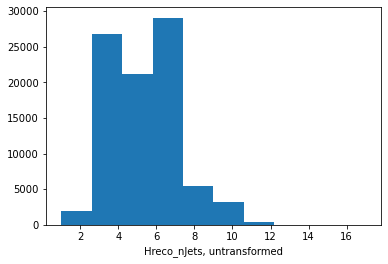

Plotting Hreco_Lep0_pt


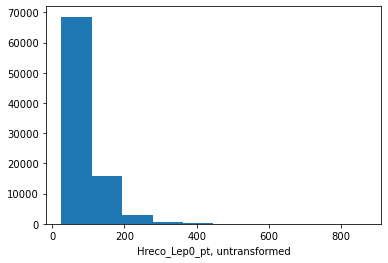

Plotting Hreco_Lep0_eta


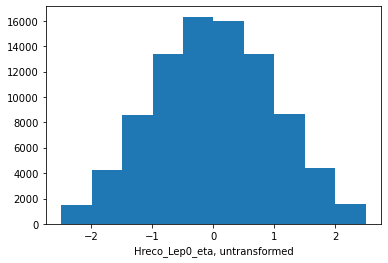

Plotting Hreco_Lep0_phi


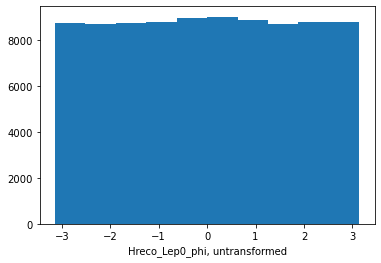

Plotting Hreco_Lep1_pt


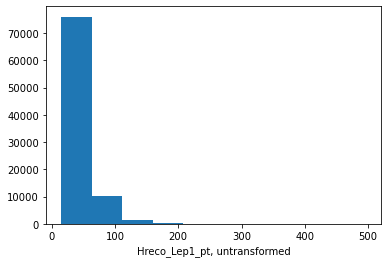

Plotting Hreco_Lep1_eta


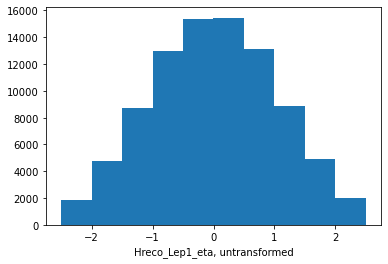

Plotting Hreco_Lep1_phi


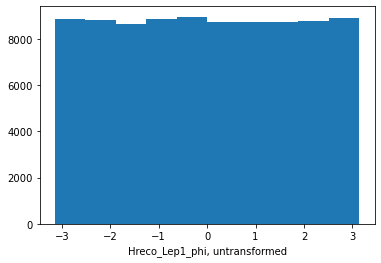

Plotting Hreco_HadTop_pt


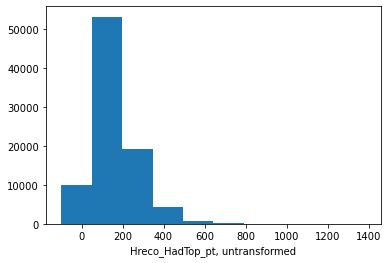

Plotting Hreco_HadTop_eta


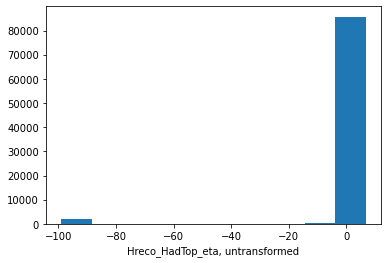

Plotting Hreco_Lep1_phi


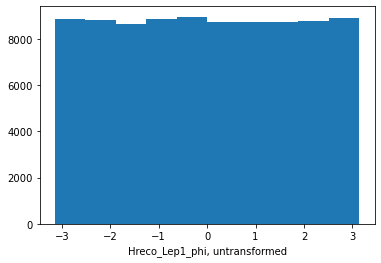

Plotting Hreco_HadTop_phi


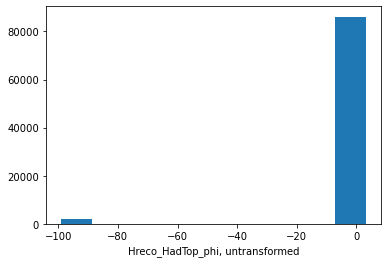

Plotting Hreco_HadTop_mass


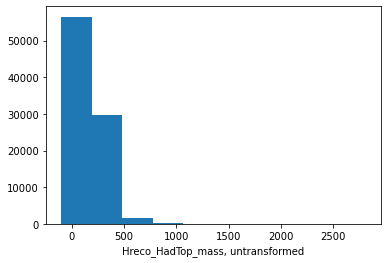

Plotting Hreco_TopScore


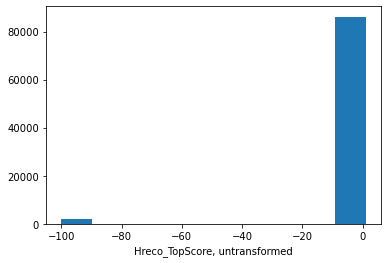

Plotting Hreco_met


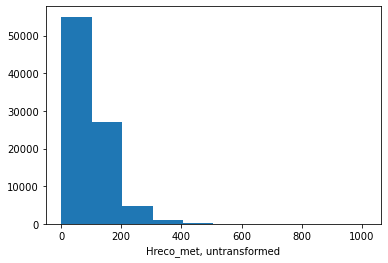

Plotting Hreco_met_phi


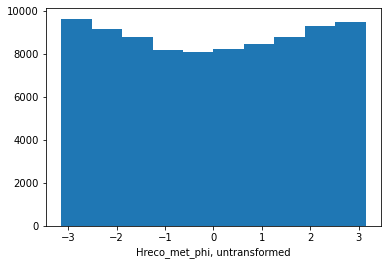

Plotting Hreco_DeltaRClosestJetToLep0


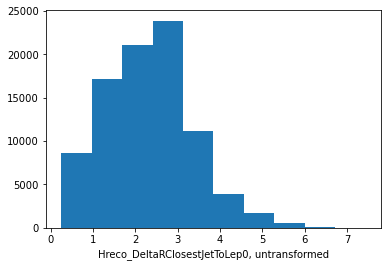

Plotting Hreco_DeltaPtClosestJetToLep0


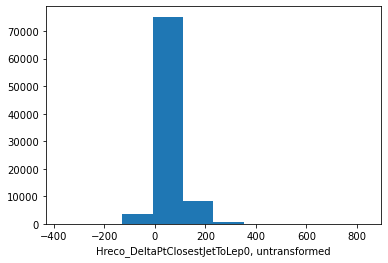

Plotting Hreco_DeltaRClosestJetToLep1


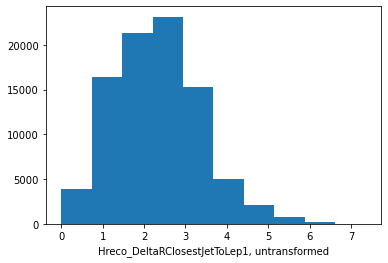

Plotting Hreco_DeltaPtClosestJetToLep1


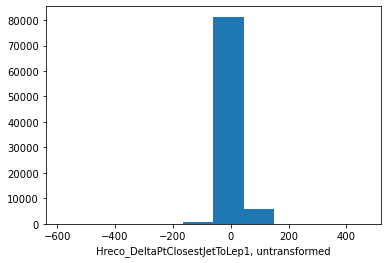

Plotting Hreco_DeltaRl0l1


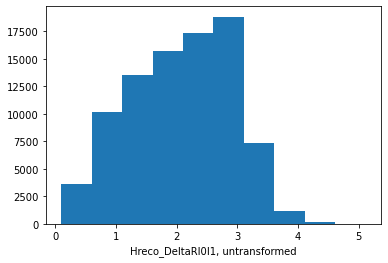

Plotting Hreco_Jet0_pt


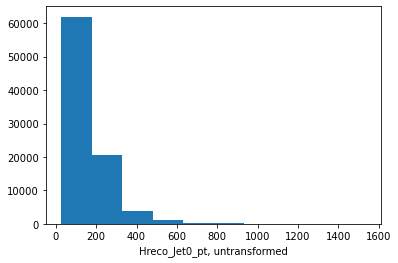

Plotting Hreco_Jet0_eta


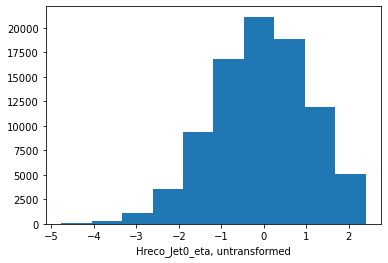

Plotting Hreco_Jet0_phi


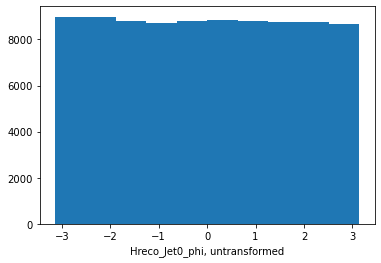

Plotting Hreco_Jet0_mass


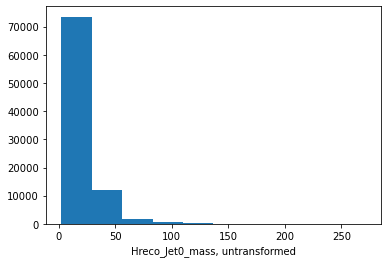

Plotting Hreco_Jet0_isbtagged


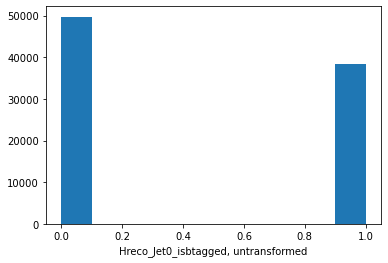

Plotting Hreco_Jet0_ishadtop


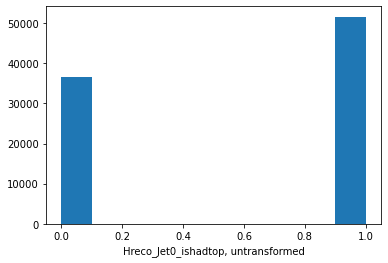

Plotting Hreco_Jet1_pt


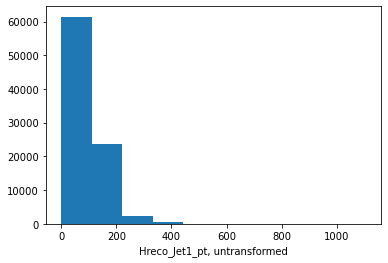

Plotting Hreco_Jet1_eta


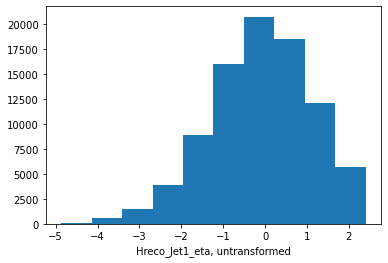

Plotting Hreco_Jet1_phi


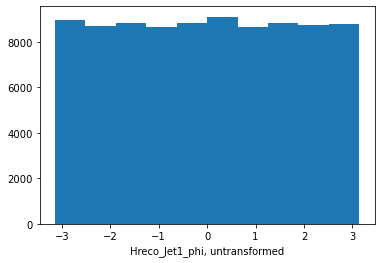

Plotting Hreco_Jet1_mass


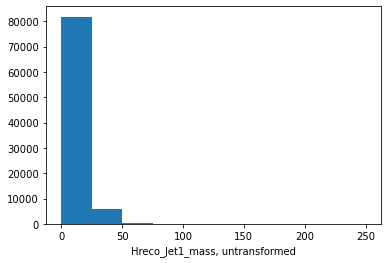

Plotting Hreco_Jet1_isbtagged


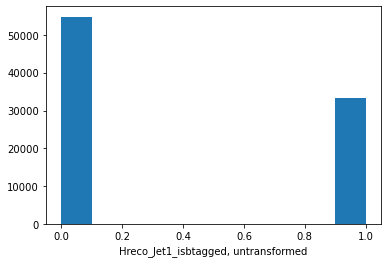

Plotting Hreco_Jet1_ishadtop


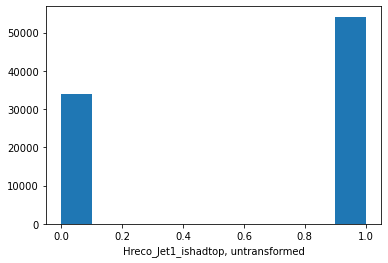

Plotting Hreco_Jet2_pt


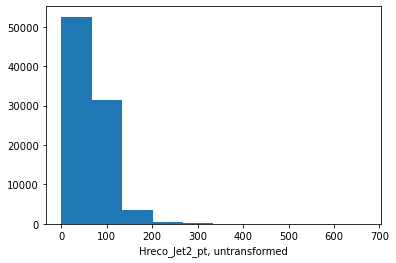

Plotting Hreco_Jet2_eta


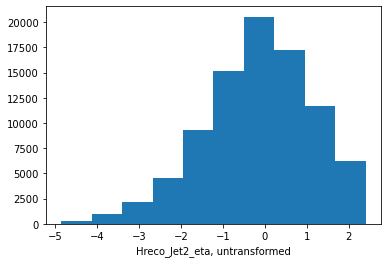

Plotting Hreco_Jet2_phi


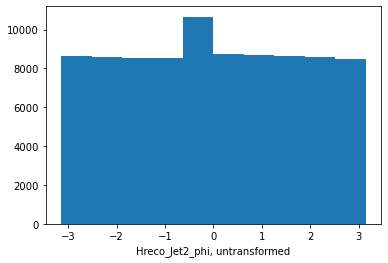

Plotting Hreco_Jet2_mass


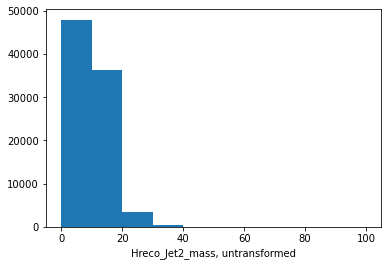

Plotting Hreco_Jet2_isbtagged


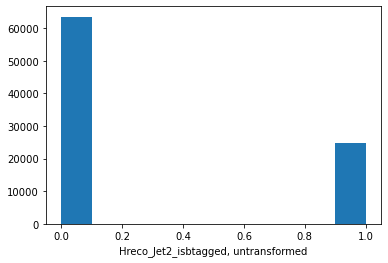

Plotting Hreco_Jet2_ishadtop


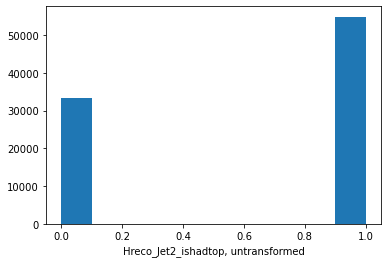

Plotting Hreco_Jet3_pt


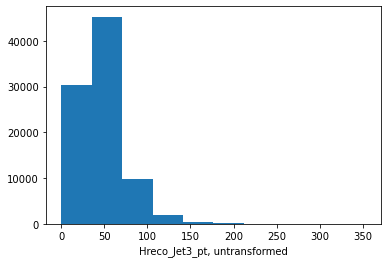

Plotting Hreco_Jet3_eta


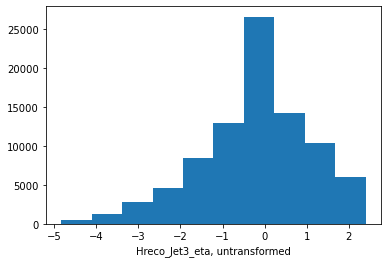

Plotting Hreco_Jet3_phi


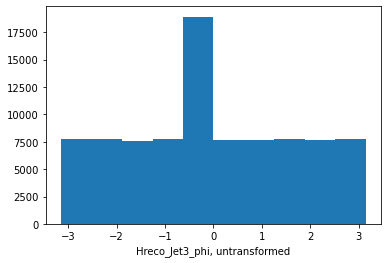

Plotting Hreco_Jet3_mass


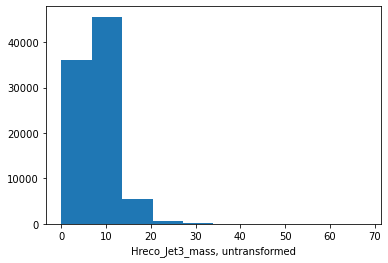

Plotting Hreco_Jet3_isbtagged


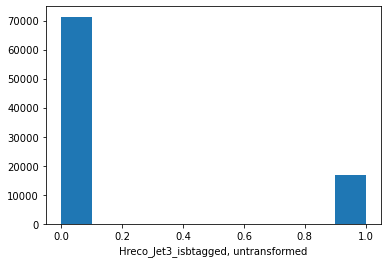

Plotting Hreco_Jet3_ishadtop


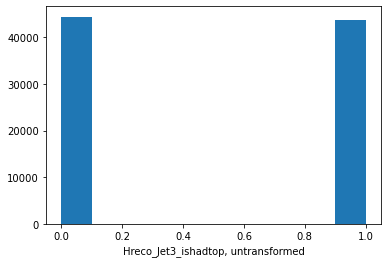

Plotting Hreco_Jet4_pt


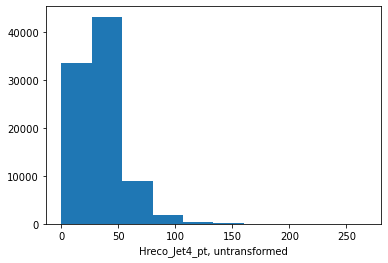

Plotting Hreco_Jet4_eta


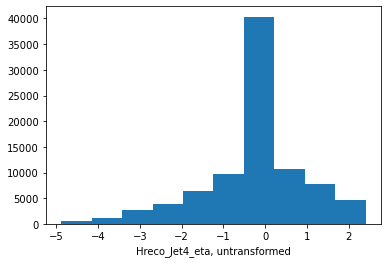

Plotting Hreco_Jet4_phi


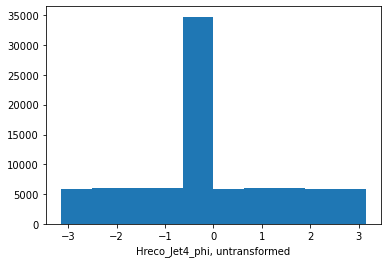

Plotting Hreco_Jet4_mass


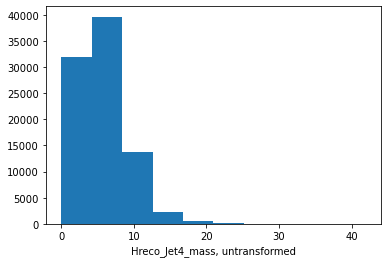

Plotting Hreco_Jet4_isbtagged


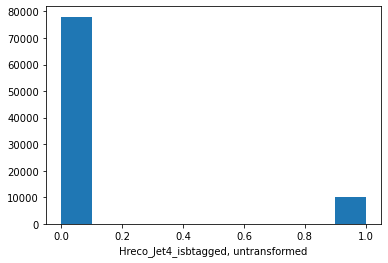

Plotting Hreco_Jet4_ishadtop


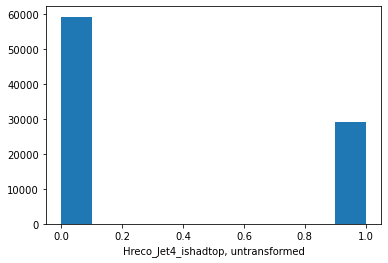

Plotting Hreco_Jet5_pt


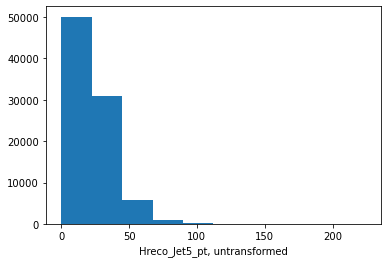

Plotting Hreco_Jet5_eta


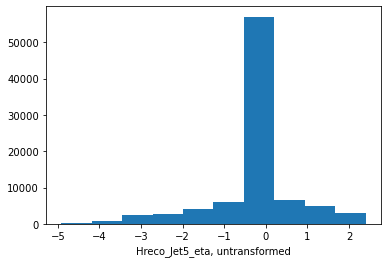

Plotting Hreco_Jet5_phi


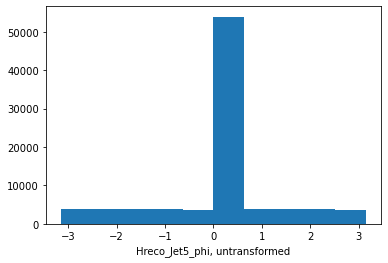

Plotting Hreco_Jet5_mass


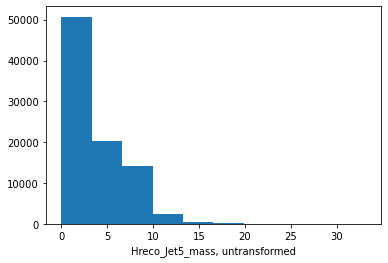

Plotting Hreco_Jet5_isbtagged


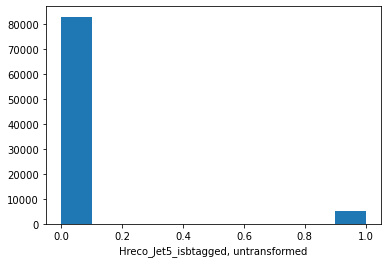

Plotting Hreco_Jet5_ishadtop


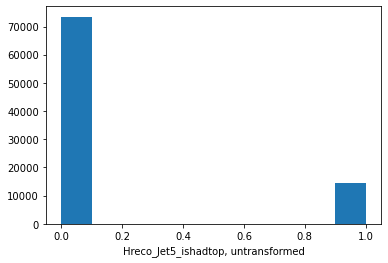

Plotting Hreco_Jet6_pt


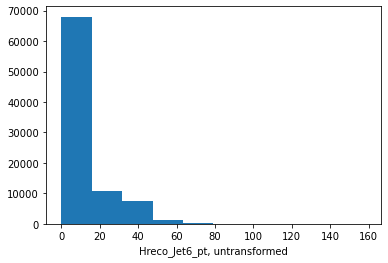

Plotting Hreco_Jet6_eta


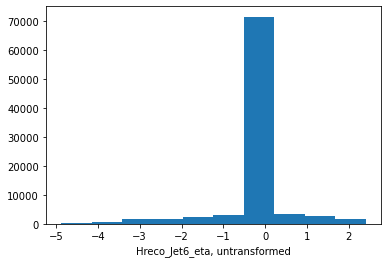

Plotting Hreco_Jet6_phi


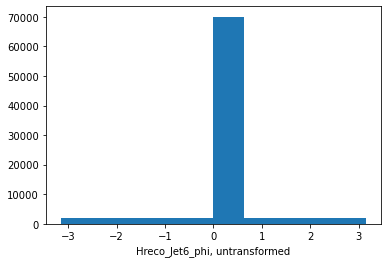

Plotting Hreco_Jet6_mass


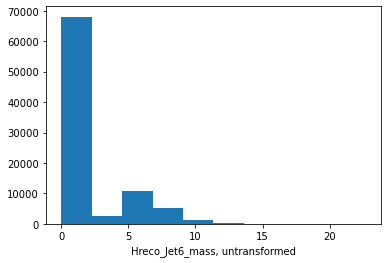

Plotting Hreco_Jet6_isbtagged


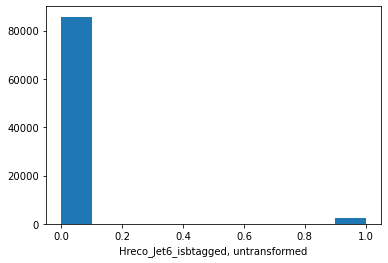

Plotting Hreco_Jet6_ishadtop


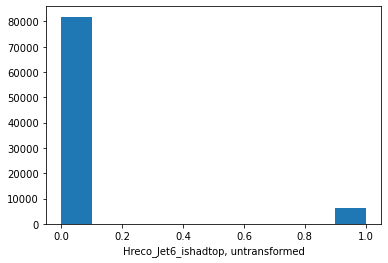

Plotting Hreco_Jet7_pt


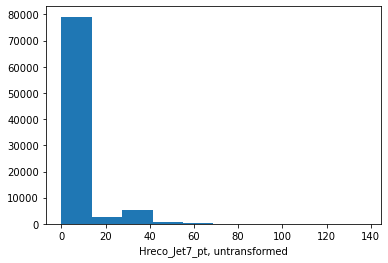

Plotting Hreco_Jet7_eta


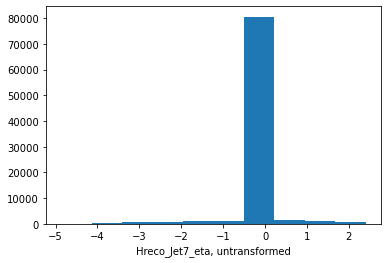

Plotting Hreco_Jet7_phi


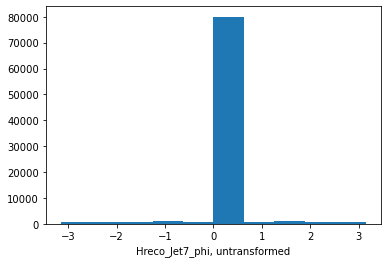

Plotting Hreco_Jet7_mass


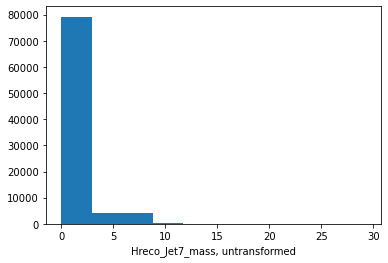

Plotting Hreco_Jet7_isbtagged


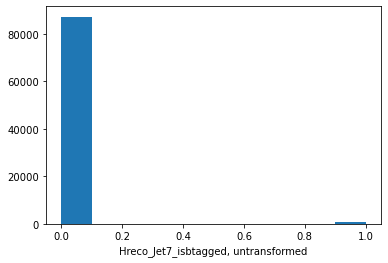

Plotting Hreco_Jet7_ishadtop


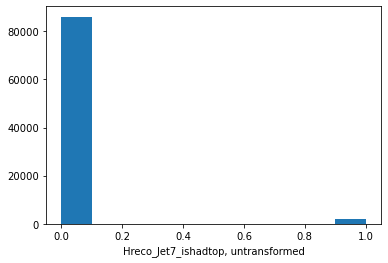

Plotting Hreco_Jet8_pt


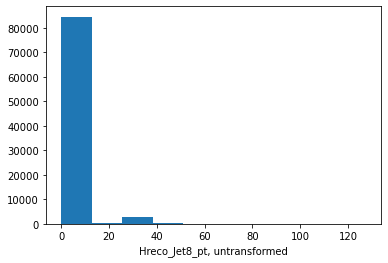

Plotting Hreco_Jet8_eta


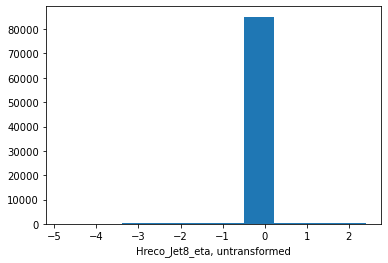

Plotting Hreco_Jet8_phi


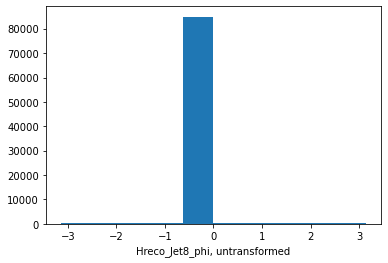

Plotting Hreco_Jet8_mass


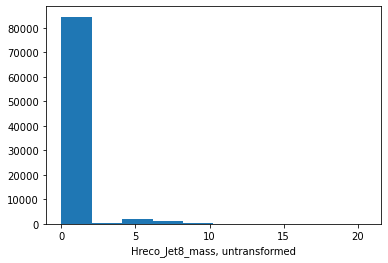

Plotting Hreco_Jet8_isbtagged


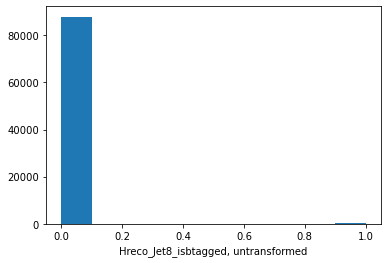

Plotting Hreco_Jet8_ishadtop


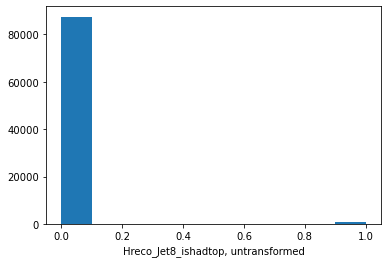

Plotting Hreco_Jet9_pt


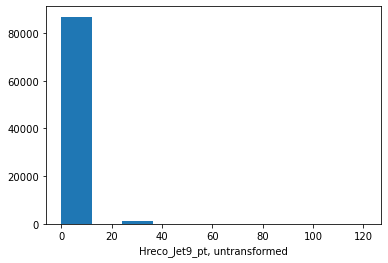

Plotting Hreco_Jet9_eta


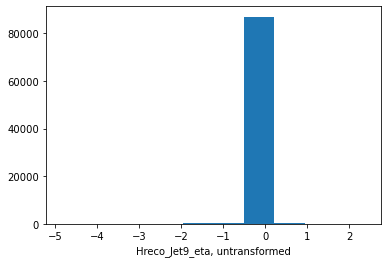

Plotting Hreco_Jet9_phi


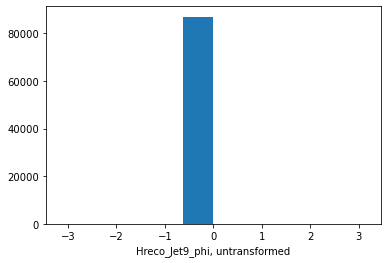

Plotting Hreco_Jet9_mass


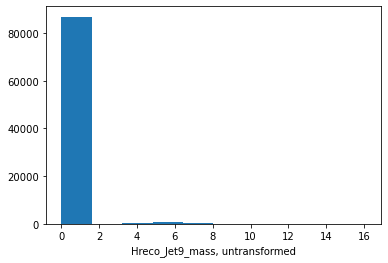

Plotting Hreco_Jet9_isbtagged


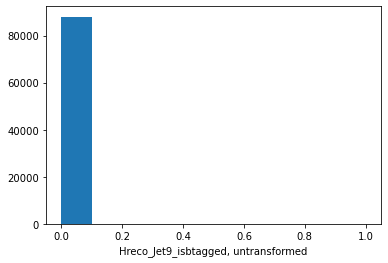

Plotting Hreco_Jet9_ishadtop


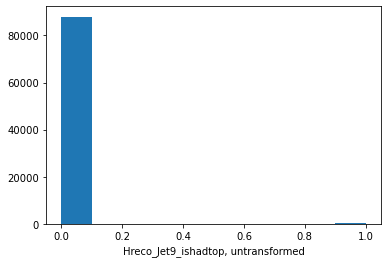

Plotting Hreco_Jet10_pt


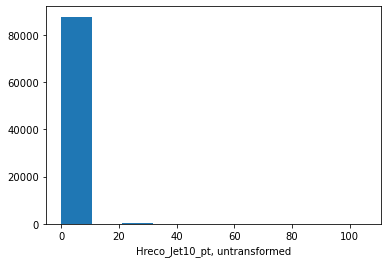

Plotting Hreco_Jet10_eta


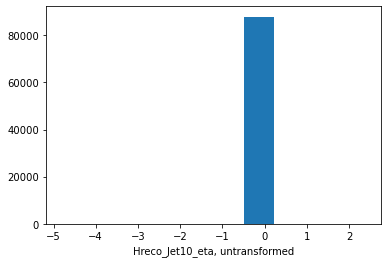

Plotting Hreco_Jet10_phi


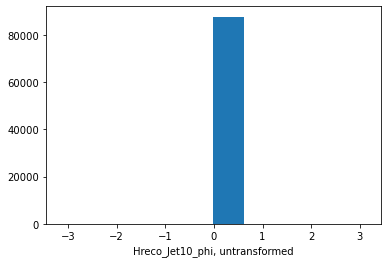

Plotting Hreco_Jet10_mass


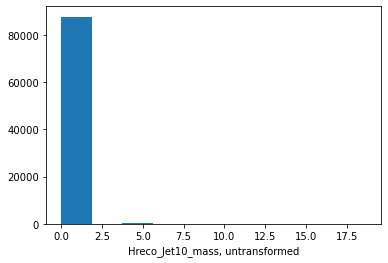

Plotting Hreco_Jet10_isbtagged


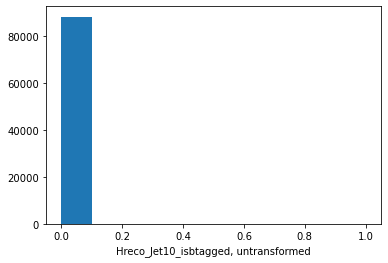

Plotting Hreco_Jet10_ishadtop


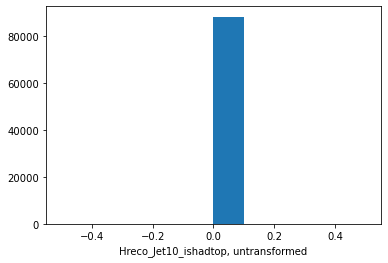

Plotting Hreco_Jet11_pt


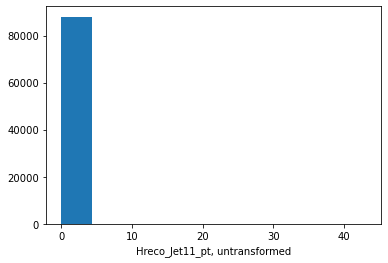

Plotting Hreco_Jet11_eta


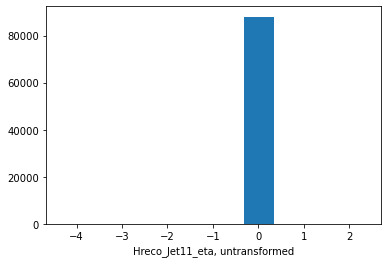

Plotting Hreco_Jet11_phi


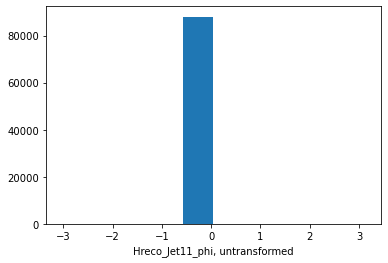

Plotting Hreco_Jet11_mass


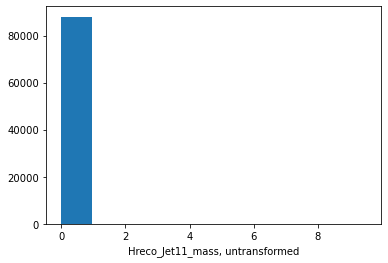

Plotting Hreco_Jet11_isbtagged


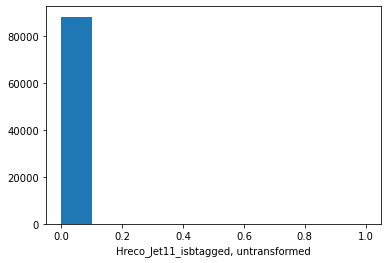

Plotting Hreco_Jet11_ishadtop


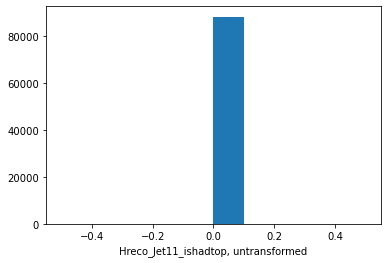

Plotting Hreco_Jet12_pt


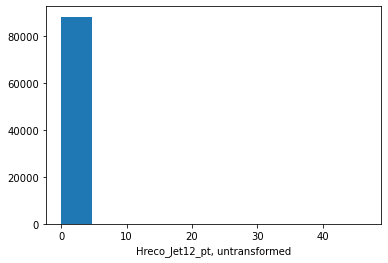

Plotting Hreco_Jet12_eta


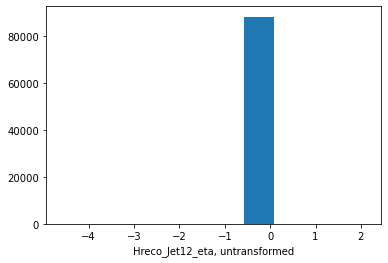

Plotting Hreco_Jet12_phi


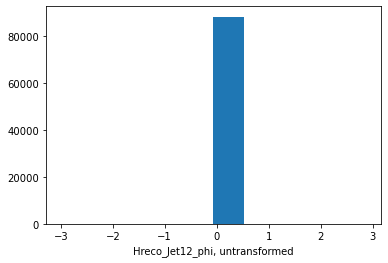

Plotting Hreco_Jet12_mass


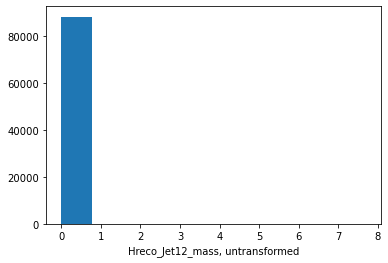

Plotting Hreco_Jet12_isbtagged


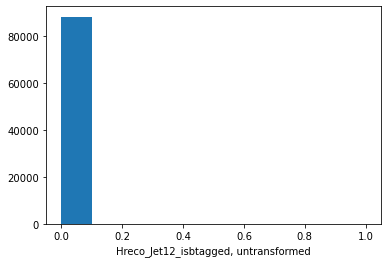

Plotting Hreco_Jet12_ishadtop


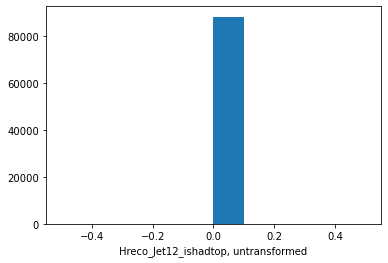

Plotting Hreco_Jet13_pt


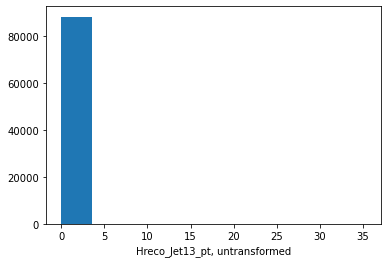

Plotting Hreco_Jet13_eta


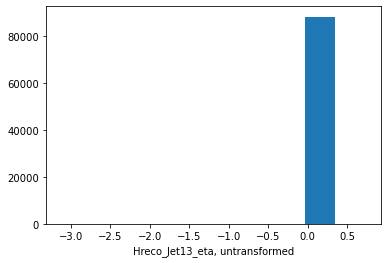

Plotting Hreco_Jet13_phi


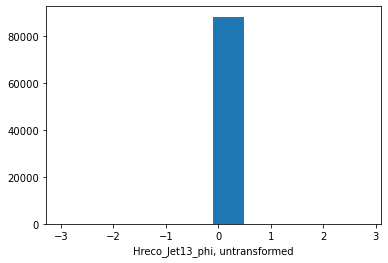

Plotting Hreco_Jet13_mass


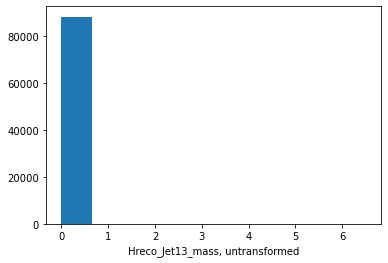

Plotting Hreco_Jet13_isbtagged


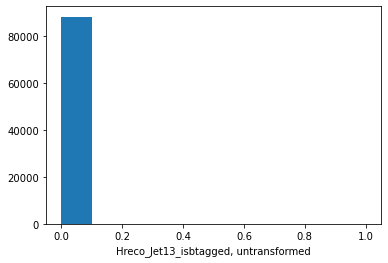

Plotting Hreco_Jet13_ishadtop


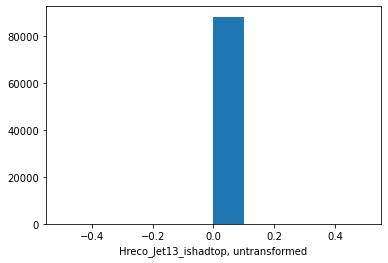

Plotting Hreco_Jet14_pt


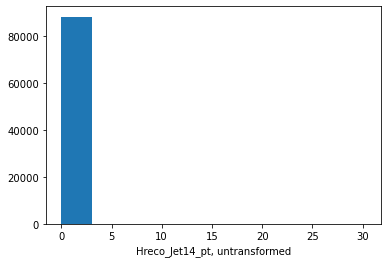

Plotting Hreco_Jet14_eta


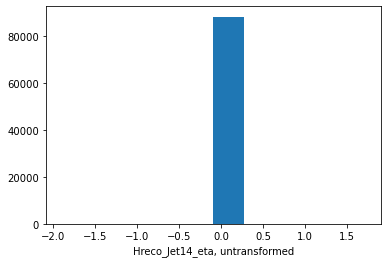

Plotting Hreco_Jet14_phi


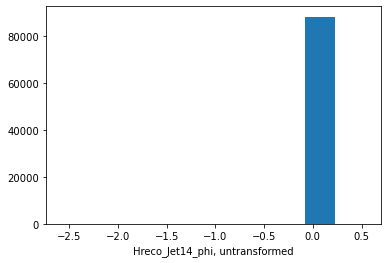

Plotting Hreco_Jet14_mass


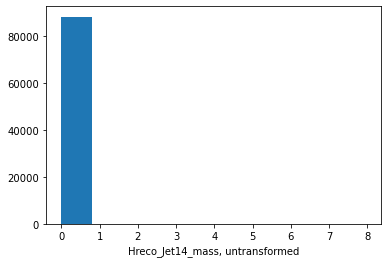

Plotting Hreco_Jet14_isbtagged


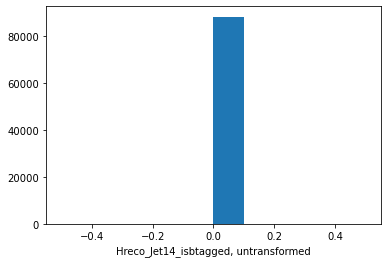

Plotting Hreco_Jet14_ishadtop


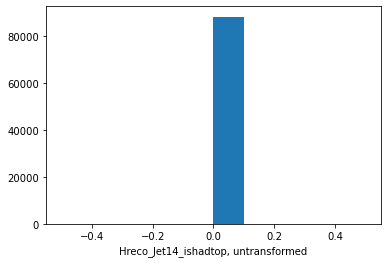

Plotting Hreco_Jet15_pt


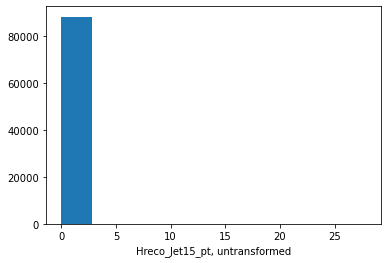

Plotting Hreco_Jet15_eta


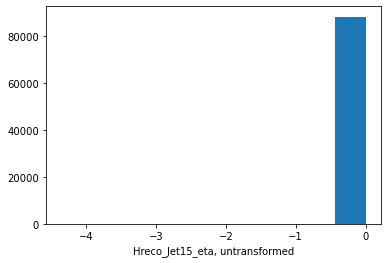

Plotting Hreco_Jet15_phi


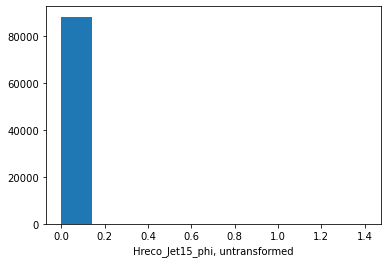

Plotting Hreco_Jet15_mass


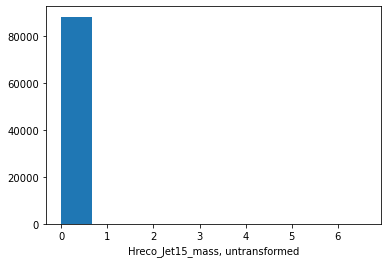

Plotting Hreco_Jet15_isbtagged


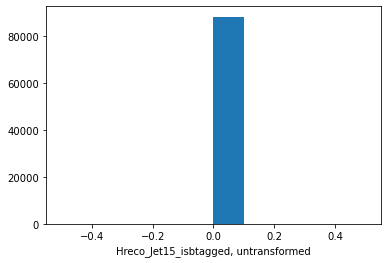

Plotting Hreco_Jet15_ishadtop


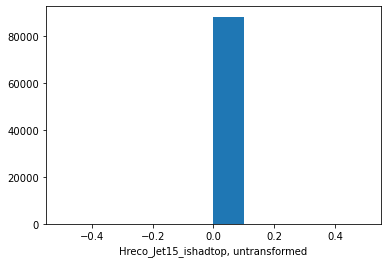

Plotting Hreco_DeltaRl0l1


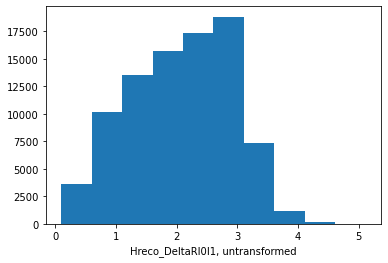

Plotting Hreco_met


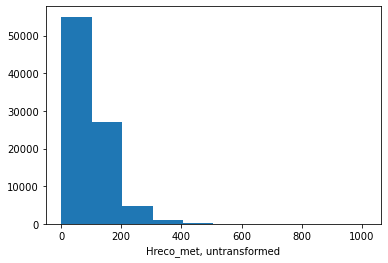

Plotting Hreco_evt_tag


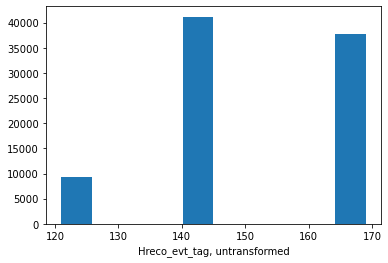

Plotting Hreco_HTXS_Higgs_pt


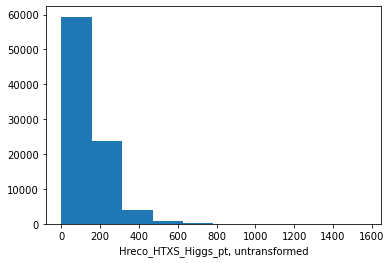

In [195]:

# Display the first few rows
viz=False
if viz:
    # pairplot is horrendously slow because it prints individually each point and keeps them in memory,
    # so plot only the first 100 entries
    myviz=data_tth.head(100) 
    sns.pairplot(myviz[thevars+target], diag_kind="kde")
    plt.show()
# Must do with subfig or something
for var in thevars+spect+target:
    print('Plotting', var)
    plt.hist(data_orig_tth[var])
    plt.xlabel('%s, untransformed'%var)
    plt.show()
    

In [196]:
# Split into datasets
# Use always the same random state (chosen by my cat) for reproducibility. Change it for random randomness
#traindataset, valdataset = train_test_split(data_tth, test_size=0.4, random_state=7)
x_train, x_test, y_train, y_test = train_test_split(data_tth[thevars], data_tth[target], random_state=7)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
preprocess=False

if preprocess:
    print('Scaling training features')
    scaler = StandardScaler()
    scaler.fit(x_train.values)
    print('Transforming training and validation features')
    x_train_scaled = scaler.transform(x_train.values)
    x_test_scaled = scaler.transform(x_test.values)
    print('Plotting transformed features for the training set')
    if viz:
        # pairplot is horrendously slow because it prints individually each point and keeps them in memory,
        # so plot only the first 100 entries
        myviz=pd.DataFrame(x_train_scaled,columns=data_tth[thevars].columns)
        myviz_short=myviz.head(100)
        sns.pairplot(myviz_short[thevars[:10]], diag_kind="kde")
        plt.show()
        for var in thevars:
            plt.hist(myviz[var])
            plt.xlabel('%s, transformed'%var)
            plt.show()
    for var in target:
        print('Now plotting training target')
        print(y_train.shape)
        plt.hist(y_train[var])
        plt.xlabel('%s, transformed'%var)
        plt.show()
print('End. I use %s variables'%len(thevars))

End. I use 117 variables


In [197]:
# The model

def my_model(lr=5e-2):
    model = Sequential()
    model.add(Dense(len(thevars), input_dim=len(thevars), kernel_initializer='glorot_normal'))#TruncatedNormal'))
    #model.add(Dropout(0.2, input_shape=(len(thevars),))) # 20% dropout for input features
    for Nnodes in [2*len(thevars),len(thevars),int(len(thevars)/2),16]:
        model.add(BatchNormalization())
        model.add(Dense(Nnodes, kernel_initializer='glorot_normal'))
        #model.add(PReLU())
        #model.add(Activation('elu'))
        model.add(LeakyReLU(alpha=0.1))
        #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    
    adam = optimizers.Adam(lr=lr,amsgrad=True) 
    #model.compile(loss='mean_absolute_percentage_error', optimizer=adam, metrics=['mse'])
    #model.compile(loss='mean_absolute_error', optimizer=adam)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    #model.compile(loss='mean_squared_logarithmic_error', optimizer=adam, metrics=['mse']) # logerror good if target range is vast
    #model.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mse']) # logerror good if target range is vast
    return model


def my_training(lr,epochs=20):
    my_regression = KerasRegressor(
        build_fn=my_model, 
        epochs=epochs, 
        batch_size=256, 
        verbose=2,
        lr=lr
)
    cb_list = [PlotLossesKeras()]
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,min_delta=0.00001)
    earlyStopping=False
    if earlyStopping:
        cb_list.append(es)
    history = my_regression.fit(
        x_train if not preprocess else x_train_scaled, 
        y_train,
        validation_data=(
            x_test if not preprocess else x_test_scaled, 
            y_test
        ),
        callbacks=cb_list
    )
    return my_regression, history


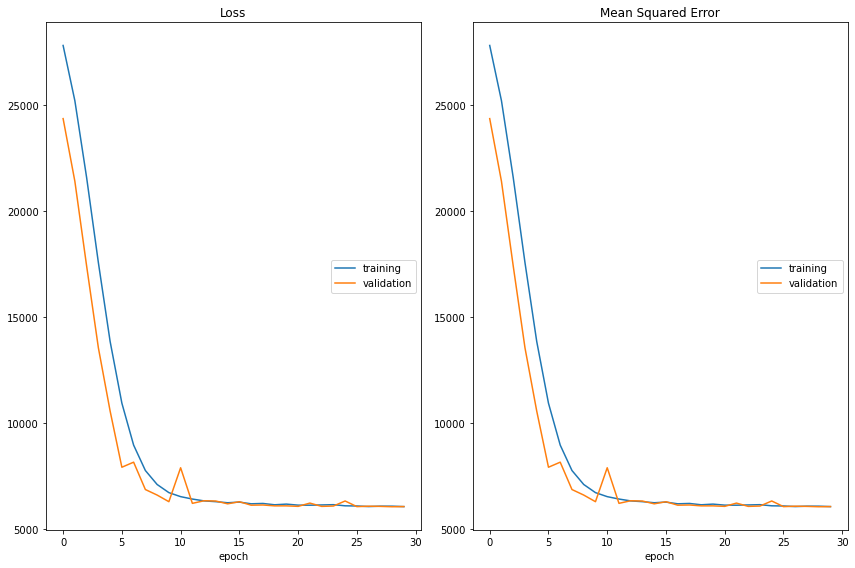

Loss
	training         	 (min: 6077.354, max: 27813.486, cur: 6077.354)
	validation       	 (min: 6071.532, max: 24365.367, cur: 6079.352)
Mean Squared Error
	training         	 (min: 6077.354, max: 27813.486, cur: 6077.354)
	validation       	 (min: 6071.532, max: 24365.367, cur: 6079.352)
259/259 - 1s - loss: 6077.3540 - mse: 6077.3540 - val_loss: 6079.3521 - val_mse: 6079.3521


In [198]:
model, hist= my_training(1e-3,epochs=30)
plt.show()


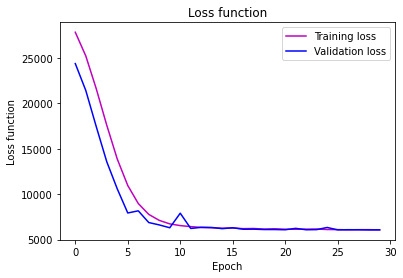

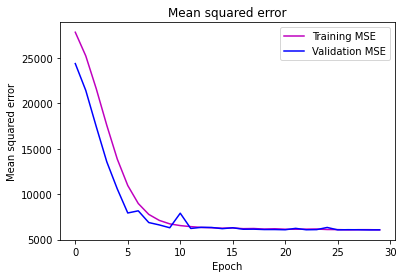

In [199]:
plt.plot(hist.history['loss'],color='m',label='Training loss')
plt.plot(hist.history['val_loss'],color='b',label='Validation loss')
plt.title('Loss function')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
plt.show()
plt.plot(hist.history['mse'], color='m', label='Training MSE')
plt.plot(hist.history['val_mse'], color='b', label='Validation MSE')
plt.title('Mean squared error')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.legend(loc='upper right')
plt.show()

import eli5
from eli5.sklearn import PermutationImportance
doperm=False
if doperm:
    showvarimp=pd.DataFrame(x_train if not preprocess else x_train_scaled,columns=data_tth[thevars].columns)
    perm = PermutationImportance(model, random_state=1).fit(showvarimp,y_train)
    eli5.show_weights(perm, feature_names = showvarimp.columns.tolist())

87/87 - 0s
SHAPES (22029,) (1, 22029)


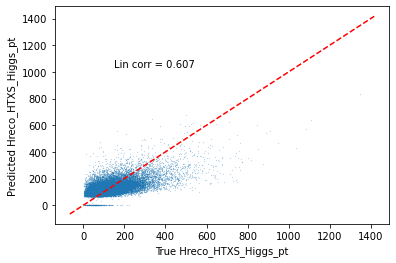

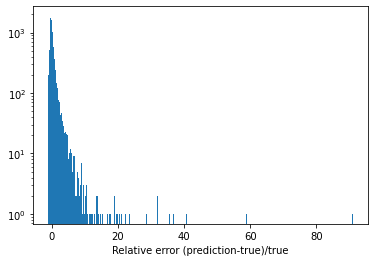

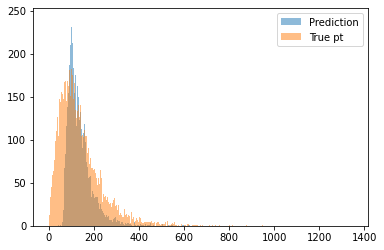

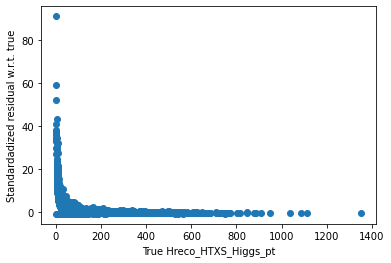

<ipython-input-200-223e0f185022>:47: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(y_test[target].values,diff/prediction.reshape(-1))


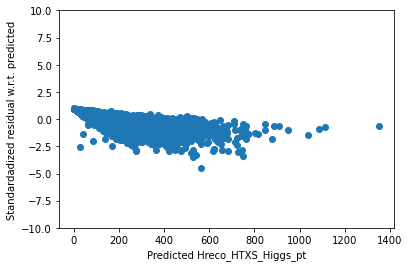

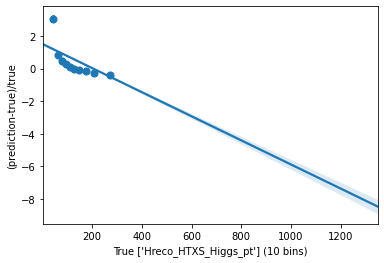

NameError: name 'bkgs' is not defined

In [200]:
# Now plot true pt vs predicted pt

import seaborn as sns

viz_x_test = x_test if not preprocess else x_test_scaled
viz_x_test=pd.DataFrame(viz_x_test,columns=data_tth[thevars].columns)
prediction = model.predict(viz_x_test.values)
lincorr = np.corrcoef(prediction, np.transpose(y_test))
print('SHAPES', prediction.shape, np.transpose(y_test).shape)
#vexp = np.vectorize(math.exp)
#blah = plt.scatter(vexp(y_test[target].values),vexp(prediction),s=0.01)
blah = plt.scatter(y_test[target].values,prediction,s=0.01)


plt.xlabel('True %s'%target[0])
plt.ylabel('Predicted %s'%target[0])
myxlim = plt.xlim()
myylim = plt.ylim()
lowcoord = min(myxlim[0],myylim[0]) if 'HTXS_Higgs_pt' not in target else 0
higcoord = max(myxlim[1],myylim[1])
_ = plt.plot([lowcoord,higcoord],[lowcoord,higcoord], c='red',ls='--')
plt.text((higcoord-lowcoord)*0.1,(higcoord-lowcoord)*0.7,'Lin corr = %.3f'%(lincorr[0,1]))
plt.show()


# Now plot the relative error between the predicted pt and true pt
diff = prediction-y_test[target].values.reshape(-1)
plt.hist(diff/y_test[target].values.reshape(-1),log=True,bins=1000)
plt.xlabel('Relative error (prediction-true)/true')
plt.show()
lincorrbacktopt=None


#plt.hist(vexp(prediction),alpha=0.5,log=False,bins=1000,label='Prediction')
#plt.hist(vexp(y_test[target].values),alpha=0.5,log=False,bins=1000,label='True pt')
#print('The SHAPES', prediction.shape, y_test[target].values.shape)
np.reshape(prediction,(prediction.shape[0],1))
plt.hist(prediction,alpha=0.5,log=False,bins=1000,label='Prediction')
plt.hist(y_test[target].values,alpha=0.5,log=False,bins=1000,label='True pt')
plt.legend(loc='upper right')
plt.show()
plt.scatter(y_test.values,diff/y_test[target].values.reshape(-1))
#plt.scatter(y_test[target].values,diff)
plt.xlabel('True %s'%target[0])
plt.ylabel('Standardadized residual w.r.t. true')
plt.show()
plt.scatter(y_test[target].values,diff/prediction.reshape(-1))
plt.ylim(-10,10)
#plt.scatter(prediction,diff)
plt.xlabel('Predicted %s'%target[0])
plt.ylabel('Standardadized residual w.r.t. predicted')
plt.show()
nxbins=10
ax = sns.regplot(y_test[target].values,diff/y_test[target].values.reshape(-1),x_bins=nxbins)
ax.set(xlabel='True %s (%s bins)'%(target,nxbins), ylabel='(prediction-true)/true')
plt.show()
if bkgs:
    ttv_prediction = model.predict(data_ttv[thevars].values)
    tt_prediction = model.predict(data_tt[thevars].values)
    ttv_manip = ttv_prediction
    tt_manip = tt_prediction
    plt.hist(prediction,alpha=0.5,density=True,log=True,bins=500,label='TTH Prediction')
    plt.hist(ttv_manip,alpha=0.5,density=True,log=True,bins=500,label='TTV Prediction')
    plt.hist(tt_manip,alpha=0.5,density=True,log=True,bins=500,label='TT Prediction')
    plt.legend(loc='upper right')
    plt.show()
print('Shape of prediction:', prediction.shape)
print('Shape of valdataset met:', viz_x_test[['met']].shape)
print('Shape of valdataset met values:', viz_x_test[['met']].values.shape)
print('Linear correlation:', lincorr)
print('Linear correlation (back to pt):', lincorrbacktopt)